<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#training" data-toc-modified-id="training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>results</a></span></li></ul></div>

# tl;dr

In this notebook we will try to make some experiments with the **Driven Harmonic Oscillator** (DHO) synthetic data. We try to learn the intensity $F_0$ of sinonoidal driven force in $$m\ddot{x} + c\dot{x} + kx = F_0\cos(\omega t + \phi_d)$$

# setup

In [1]:
import pprint
import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

# neural network architecture

In [160]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))  # Add batch normalization layer
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;


$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

# data

wprime = 3.1621788374473705
10.0 1 9


,time,displacement
0,0.000000,0.000000
1,0.080321,0.231526
2,0.160643,0.434919
3,0.240964,0.598351
4,0.321285,0.713253


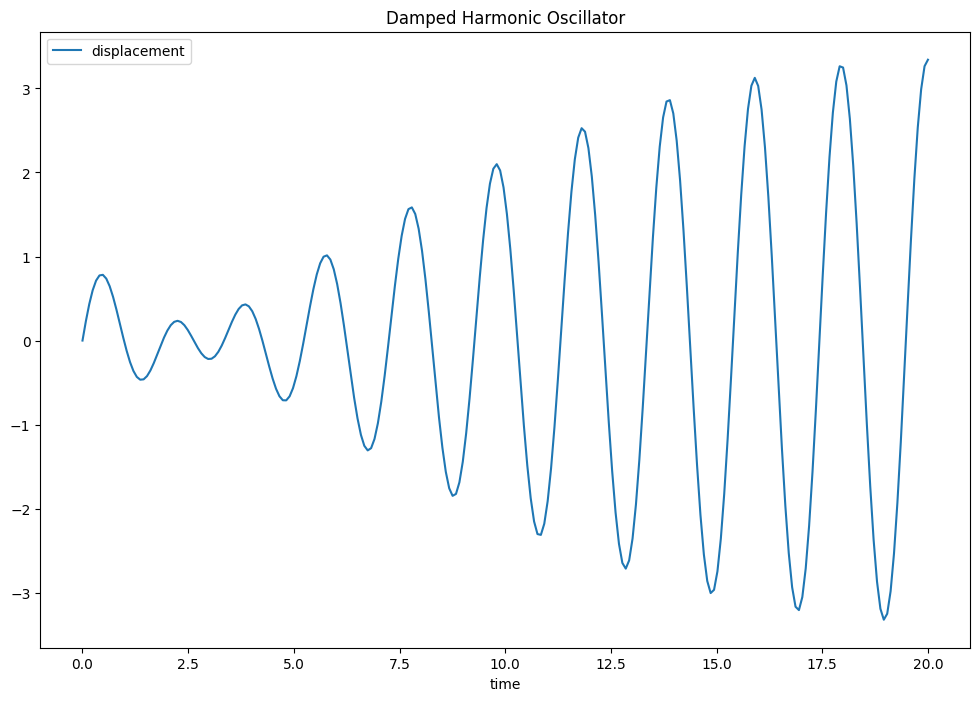

In [161]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")

# min_max_scaler = MinMaxScaler()
# X["time"] = min_max_scaler.fit_transform(X["time"].values.reshape(-1, 1))

def driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid):
    w0 = np.sqrt(k/m)
    gamma = c/2/m
    
    wprime = np.sqrt(w0**2 - gamma**2)
    print(f"wprime = {wprime}")
    A = F0 / m / np.sqrt((w0**2 - w**2)**2 + 4 * gamma**2 * w**2 )
    
    print(k, m, w**2)
    phi = np.arctan(c * w / (k - m * w**2)) - phid
    phih = np.arctan(wprime * (x0 - A * np.cos(phi)) \
        / (v0 + gamma * (x0 - A * np.cos(phi)) - A * w * np.sin(phi) ) )
    
    Ah = (x0 - A * np.cos(phi)) / np.sin(phih)
    
    x = Ah * np.exp(-gamma * t) * np.sin(wprime * t + phih) + A * np.cos(w * t - phi)
    
    return x

d, w0 = 2, 20
m = 1
k = 1e1
c = 0.05
w = 3
F0 = 2
x0 = 0
v0 = 3
phid = np.pi

x = torch.linspace(0,20,250).view(-1,1)
y = driven_oscillator(x, m, k, c, w0, w, F0, x0, v0, phid)

X = pd.DataFrame({"time": x.squeeze(), "displacement": y.squeeze()})

display(X.head())

X.plot(x="time", y="displacement", figsize=(12, 8), title="Damped Harmonic Oscillator") ;

# training

In [179]:
time_threshold = 20

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|          | 0/30000 [00:00<?, ?it/s]

/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|▎         | 1034/30000 [00:04<02:40, 181.01it/s]

F0:  4.0730204582214355
Data Loss: 2.506107, Physics Loss: 7.494760, x0 Loss: 0.000006, v0 Loss: 0.009222, Total Loss: 2.513611


  7%|▋         | 2038/30000 [00:09<02:14, 207.54it/s]

F0:  3.235607862472534
Data Loss: 2.505566, Physics Loss: 4.731536, x0 Loss: 0.000001, v0 Loss: 0.001777, Total Loss: 2.510299


 10%|█         | 3035/30000 [00:13<02:05, 214.71it/s]

F0:  2.448326587677002
Data Loss: 2.505216, Physics Loss: 2.737826, x0 Loss: 0.000000, v0 Loss: 0.000178, Total Loss: 2.507954


 13%|█▎        | 4022/30000 [00:18<02:19, 186.60it/s]

F0:  1.7374540567398071
Data Loss: 2.504925, Physics Loss: 1.385499, x0 Loss: 0.000023, v0 Loss: 0.000178, Total Loss: 2.506311


 17%|█▋        | 5034/30000 [00:23<01:20, 311.30it/s]

F0:  1.1232346296310425
Data Loss: 2.504713, Physics Loss: 0.617074, x0 Loss: 0.000003, v0 Loss: 0.000217, Total Loss: 2.505330


 20%|██        | 6029/30000 [00:28<02:06, 189.61it/s]

F0:  0.629155158996582
Data Loss: 2.504821, Physics Loss: 0.299966, x0 Loss: 0.000001, v0 Loss: 0.000338, Total Loss: 2.505121


 23%|██▎       | 7039/30000 [00:33<02:02, 187.86it/s]

F0:  0.3026081621646881
Data Loss: 2.504505, Physics Loss: 0.168783, x0 Loss: 0.000024, v0 Loss: 0.000000, Total Loss: 2.504674


 27%|██▋       | 8019/30000 [00:38<02:01, 181.59it/s]

F0:  0.15922121703624725
Data Loss: 2.504470, Physics Loss: 0.154952, x0 Loss: 0.000029, v0 Loss: 0.000001, Total Loss: 2.504625


 30%|███       | 9036/30000 [00:44<01:51, 188.85it/s]

F0:  0.1291407197713852
Data Loss: 2.504447, Physics Loss: 0.155643, x0 Loss: 0.000028, v0 Loss: 0.000000, Total Loss: 2.504603


 33%|███▎      | 10032/30000 [00:49<01:48, 184.18it/s]

F0:  0.1291503757238388
Data Loss: 2.504376, Physics Loss: 0.162774, x0 Loss: 0.000029, v0 Loss: 0.000000, Total Loss: 2.504539


 37%|███▋      | 11034/30000 [00:54<01:27, 216.03it/s]

F0:  0.12966306507587433
Data Loss: 2.504325, Physics Loss: 0.163720, x0 Loss: 0.000027, v0 Loss: 0.000000, Total Loss: 2.504489


 40%|████      | 12030/30000 [00:59<01:12, 248.94it/s]

F0:  0.1294824630022049
Data Loss: 2.504225, Physics Loss: 0.165544, x0 Loss: 0.000025, v0 Loss: 0.000000, Total Loss: 2.504390


 43%|████▎     | 13033/30000 [01:03<01:31, 185.93it/s]

F0:  0.14063026010990143
Data Loss: 2.502730, Physics Loss: 0.211233, x0 Loss: 0.000015, v0 Loss: 0.000019, Total Loss: 2.502941


 47%|████▋     | 14048/30000 [01:07<01:01, 257.56it/s]

F0:  0.8916322588920593
Data Loss: 2.316960, Physics Loss: 6.199363, x0 Loss: 0.000051, v0 Loss: 0.000014, Total Loss: 2.323159


 50%|█████     | 15035/30000 [01:11<01:00, 247.04it/s]

F0:  1.7881934642791748
Data Loss: 1.504391, Physics Loss: 13.799166, x0 Loss: 0.000058, v0 Loss: 0.000070, Total Loss: 1.518190


 53%|█████▎    | 16028/30000 [01:16<01:14, 187.81it/s]

F0:  2.2878124713897705
Data Loss: 0.863623, Physics Loss: 16.129398, x0 Loss: 0.000011, v0 Loss: 0.000001, Total Loss: 0.879753


 57%|█████▋    | 17020/30000 [01:21<01:11, 182.13it/s]

F0:  2.669063091278076
Data Loss: 0.373160, Physics Loss: 11.382372, x0 Loss: 0.000020, v0 Loss: 0.000054, Total Loss: 0.384543


 60%|██████    | 18043/30000 [01:26<00:38, 313.63it/s]

F0:  3.0178065299987793
Data Loss: 0.207225, Physics Loss: 11.126314, x0 Loss: 0.000040, v0 Loss: 0.000001, Total Loss: 0.218351


 63%|██████▎   | 19019/30000 [01:29<00:54, 200.36it/s]

F0:  2.924203634262085
Data Loss: 0.052998, Physics Loss: 10.308606, x0 Loss: 0.000052, v0 Loss: 0.000020, Total Loss: 0.063306


 67%|██████▋   | 20026/30000 [01:34<00:54, 183.35it/s]

F0:  2.8726625442504883
Data Loss: 0.002139, Physics Loss: 7.503111, x0 Loss: 0.000000, v0 Loss: 0.001068, Total Loss: 0.009643


 70%|███████   | 21033/30000 [01:38<00:33, 269.33it/s]

F0:  2.904741048812866
Data Loss: 0.001225, Physics Loss: 6.058810, x0 Loss: 0.000000, v0 Loss: 0.000582, Total Loss: 0.007284


 73%|███████▎  | 22043/30000 [01:42<00:29, 271.16it/s]

F0:  2.8570914268493652
Data Loss: 0.001484, Physics Loss: 4.321215, x0 Loss: 0.000005, v0 Loss: 0.000244, Total Loss: 0.005805


 77%|███████▋  | 23028/30000 [01:46<00:30, 231.67it/s]

F0:  2.765813112258911
Data Loss: 0.000660, Physics Loss: 2.874913, x0 Loss: 0.000001, v0 Loss: 0.000064, Total Loss: 0.003535


 80%|████████  | 24043/30000 [01:50<00:23, 256.40it/s]

F0:  2.613374948501587
Data Loss: 0.000536, Physics Loss: 1.435079, x0 Loss: 0.000002, v0 Loss: 0.000005, Total Loss: 0.001971


 83%|████████▎ | 25041/30000 [01:54<00:18, 271.50it/s]

F0:  2.4671459197998047
Data Loss: 0.000422, Physics Loss: 0.708550, x0 Loss: 0.000001, v0 Loss: 0.000002, Total Loss: 0.001131


 87%|████████▋ | 26036/30000 [01:59<00:16, 233.45it/s]

F0:  2.381585121154785
Data Loss: 0.000368, Physics Loss: 0.450767, x0 Loss: 0.000001, v0 Loss: 0.000003, Total Loss: 0.000819


 90%|█████████ | 27029/30000 [02:03<00:15, 186.51it/s]

F0:  2.344806432723999
Data Loss: 0.000317, Physics Loss: 0.352148, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.000669


 93%|█████████▎| 28034/30000 [02:08<00:10, 192.78it/s]

F0:  2.323725461959839
Data Loss: 0.001034, Physics Loss: 0.306348, x0 Loss: 0.000004, v0 Loss: 0.000000, Total Loss: 0.001340


 97%|█████████▋| 29030/30000 [02:13<00:05, 187.05it/s]

F0:  2.3087658882141113
Data Loss: 0.000244, Physics Loss: 0.260800, x0 Loss: 0.000000, v0 Loss: 0.000002, Total Loss: 0.000505


100%|██████████| 30000/30000 [02:19<00:00, 215.68it/s]


F0:  2.2791473865509033
Data Loss: 0.011941, Physics Loss: 0.391800, x0 Loss: 0.000209, v0 Loss: 0.000052, Total Loss: 0.012333


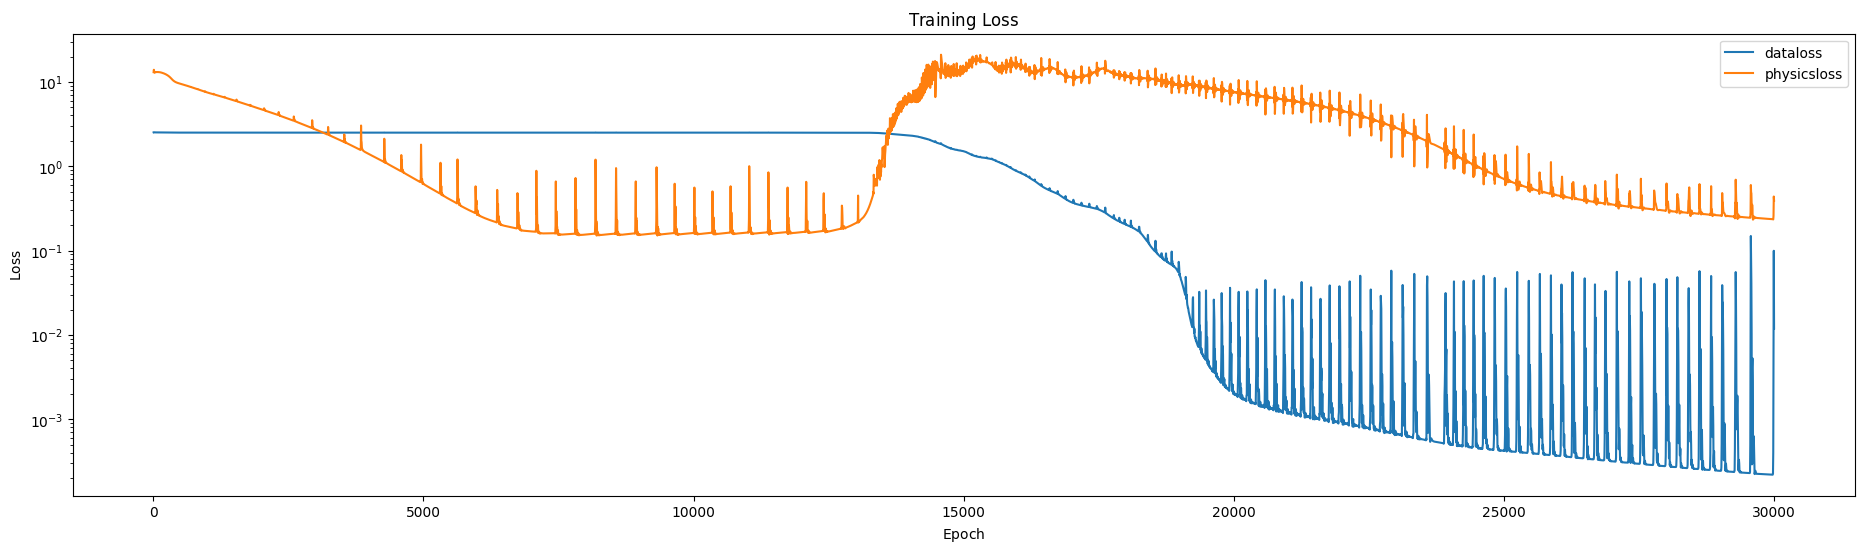

In [180]:
torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query(f"time <= {time_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query(f"time <= {time_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query(f"time > {time_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query(f"time > {time_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 32,
    'num_epochs': 30000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

_locations = torch.linspace(0, 20, 50).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_c = torch.tensor(c, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_w = torch.tensor(w, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v0, dtype=torch.float, requires_grad=False).to(device)
_phid = torch.tensor(phid, dtype=torch.float, requires_grad=False).to(device)
_F0 = torch.tensor(5, dtype=torch.float, requires_grad=True, device=device)

model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model.to(device)
optimizer = optim.Adam([{"params": model.parameters()}, {"params": [_F0]}], lr=learning_rate)
criterion = nn.MSELoss()

print(model)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
    dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

    
    _diff_equation = _m*dy2dt2 + _c*dydt + _k*y_location_hat - _F0*torch.cos(_w*_locations-_phid)
    physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))
    _x0_loss = criterion(y_location_hat[0], _x0)
    _v0_loss = criterion(dydt[0], _v0)

    loss = data_loss + (1e-3)*(physics_loss + _x0_loss + _v0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print("F0: ", _F0.item())
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss", figsize=(23, 6), ax=ax1)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

ax1.set_yscale('log')

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_pinn.png", dpi=300, bbox_inches="tight") ;

# results

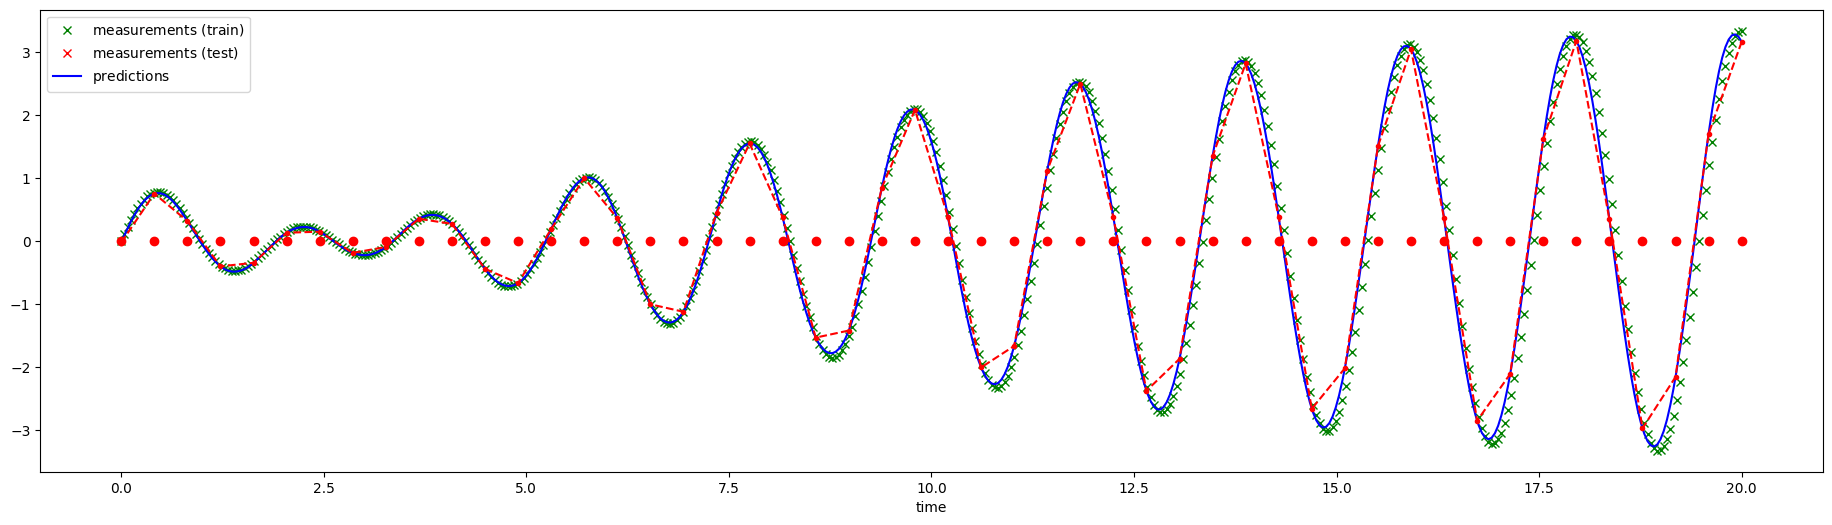

In [181]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query(f"time <= {time_threshold}").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query(f"time > {time_threshold}").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
)

# # plot theoretical curve
# m = 1
# k = 1
# mu = 0.1
# x_0 = 1
# v_0 = 0

# omega_0 = np.sqrt(k/m)
# delta = mu/(2*m)
# omega = np.sqrt(omega_0**2 - delta**2)

# t = np.linspace(0, 50, 1000)
# x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
# ax1.plot(
#     t.reshape(-1, 1),
#     x, 
#     c="k", linestyle="--", 
#     label=r"$\text{exact solution}$"
# )

# ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
# ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
# ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

# plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
# ax1.legend()

# plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_pinn.png", dpi=300, bbox_inches="tight") ;

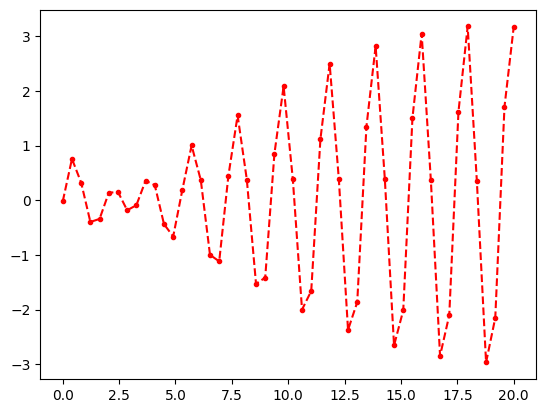

In [182]:
model.eval()
with torch.no_grad():
    plt.plot(
        _locations.cpu().detach().numpy().reshape(-1, 1),
        model(_locations).cpu().detach().numpy().reshape(-1), 
        c="r", linestyle="--", marker=".",
        label=r"$\text{locations prediction}$"
    )

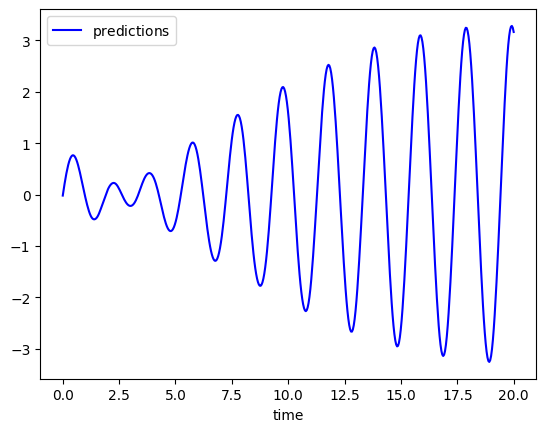

In [183]:
X.plot(
    x="time", 
    y="y_hat",
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
) ;

wprime = 3.1621788374473705
10.0 1 9


,time,displacement
0,0.000000,0.000000
1,0.040080,0.118889
2,0.080160,0.233830
3,0.120240,0.343027
4,0.160321,0.444807


wprime = 3.1621788374473705
10.0 1 9


,time,displacement
0,0.000000,0.000000
1,0.040080,0.118198
2,0.080160,0.231086
3,0.120240,0.336935
4,0.160321,0.434177


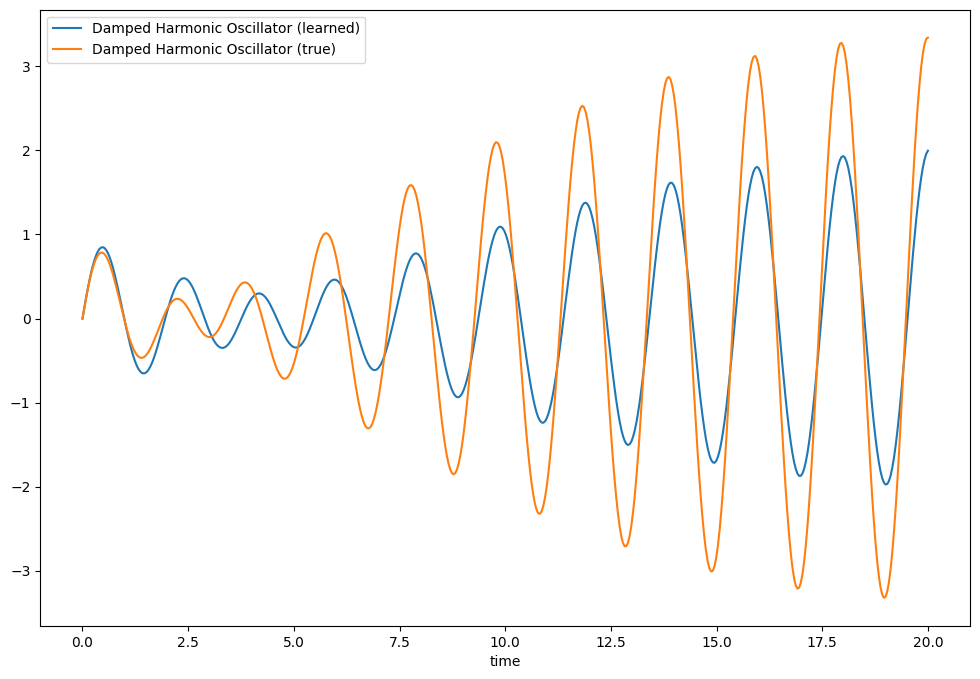

In [178]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))


x = torch.linspace(0,20,500).view(-1,1)
y = driven_oscillator(x, m, k, c, w0, w, _F0.item(), x0, v0, phid)
X = pd.DataFrame({"time": x.squeeze(), "displacement": y.squeeze()})
display(X.head())
X.plot(x="time", y="displacement", figsize=(12, 8), label="Damped Harmonic Oscillator (learned)", ax=ax1)

x = torch.linspace(0,20,500).view(-1,1)
y = driven_oscillator(x, m, k, c, w0, w, F0, x0, v0, phid)
X = pd.DataFrame({"time": x.squeeze(), "displacement": y.squeeze()})
display(X.head())
X.plot(x="time", y="displacement", figsize=(12, 8), label="Damped Harmonic Oscillator (true)", ax=ax1)

ax1.legend()

.